In [2]:
import pandas as pd

## Dataset Overview and initial cleaning

In [3]:
data = pd.read_csv('power_data.csv')
data.head()

,Unnamed: 0,Datetime,Power_MWH
0,0,2010-01-01 00:00:00,31647.0
1,1,2010-12-31 01:00:00,29634.0
2,2,2010-12-31 02:00:00,28614.0
3,3,2010-12-31 03:00:00,28146.0
4,4,2010-12-31 04:00:00,28051.0


There's an additional unnecessary column for column. We can delete it.

In [4]:
data.drop(['Unnamed: 0'], axis=1, inplace=True)

In [5]:
# Check for missing values
missing_values = data.isnull().sum()
print("Missing Values:\n", missing_values)

# Check for duplicates
duplicates = data.duplicated().sum()
print("Duplicate Rows:", duplicates)

Missing Values:
 Datetime     0
Power_MWH    0
dtype: int64
Duplicate Rows: 0


The datatime column should be the index column as we are working with timeseries data. Also, we can see that the Datetime column is not sorted.

In [6]:
data['Datetime'] = pd.to_datetime(data['Datetime'])

# Set the 'Datetime' column as the index
data.set_index('Datetime', inplace=True)

# Sort the dataset
data.sort_index(inplace=True)

data.head()

,Power_MWH
Datetime,
2010-01-01 00:00:00,31647.0
2010-01-01 01:00:00,30075.0
2010-01-01 02:00:00,28907.0
2010-01-01 03:00:00,27906.0
2010-01-01 04:00:00,27373.0


In [7]:
# Print the shape of the dataset
print(f"The dataset has {data.shape[0]} rows and {data.shape[1]} columns.")

The dataset has 75255 rows and 1 columns.


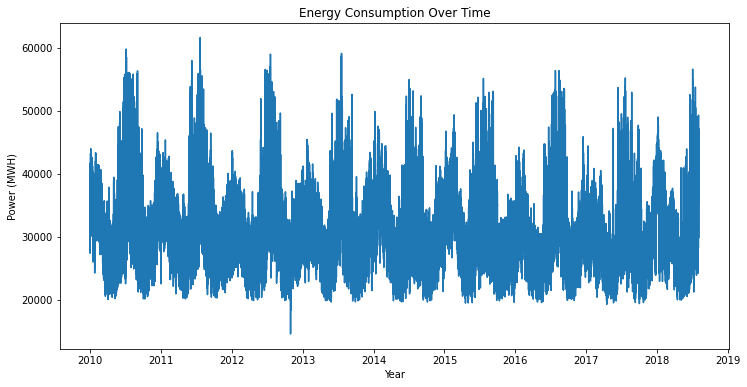

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Power_MWH'])
plt.xlabel('Year')
plt.ylabel('Power (MWH)')
plt.title('Energy Consumption Over Time')
plt.show()


Based on the figure above, it can be determined that the dataset contains a few outliers, which are approximately greater than 60,000 MW, and a single outlier which is significantly smaller than approximately 20,000 MW. These outliers will be replaced with the mean of the column to improve the performance of the time series analysis.

In [9]:
import numpy as np
q1 = np.percentile(data["Power_MWH"], 25)

# Calculate the third quartile (Q3)
q3 = np.percentile(data["Power_MWH"], 75)

# Calculate the interquartile range (IQR)
iqr = q3 - q1

# Define the lower and upper thresholds for outliers
lower_threshold = q1 - 1.5 * iqr
upper_threshold = q3 + 1.5 * iqr

# Find the outliers
outliers = [x for x in data["Power_MWH"] if x < lower_threshold or x > upper_threshold]

# Print the number of outliers
print("Number of Outliers:", len(outliers))

# Print the outliers
print("Outliers:", outliers)


Number of Outliers: 1827
Outliers: [48090.0, 48025.0, 47793.0, 48450.0, 49267.0, 49873.0, 49059.0, 47969.0, 48675.0, 49235.0, 49286.0, 48378.0, 47815.0, 49163.0, 50068.0, 50850.0, 51425.0, 51375.0, 50008.0, 47951.0, 48238.0, 49568.0, 50332.0, 50479.0, 50224.0, 49528.0, 48086.0, 48798.0, 50374.0, 51822.0, 52840.0, 53473.0, 53995.0, 54070.0, 52924.0, 51233.0, 49705.0, 48355.0, 50449.0, 52861.0, 54046.0, 55251.0, 55165.0, 53356.0, 51601.0, 50910.0, 50006.0, 48408.0, 48432.0, 49007.0, 49439.0, 48851.0, 47568.0, 48851.0, 49938.0, 50771.0, 51011.0, 50467.0, 49096.0, 48397.0, 47679.0, 48831.0, 51737.0, 53708.0, 54996.0, 55787.0, 55070.0, 53452.0, 52139.0, 51192.0, 50331.0, 49111.0, 48123.0, 47886.0, 48981.0, 49742.0, 50135.0, 50119.0, 50068.0, 49670.0, 48147.0, 49257.0, 50367.0, 51843.0, 52894.0, 53396.0, 52706.0, 51132.0, 49803.0, 48656.0, 47815.0, 51737.0, 54964.0, 56877.0, 58239.0, 58923.0, 59580.0, 59807.0, 59482.0, 58643.0, 56742.0, 55364.0, 53806.0, 49732.0, 49044.0, 52334.0, 55252.0, 5

There are 1827 outliers. We can either remove them or replace them with a fixed value like the mean of the Power_MWH column. Since they are an small fraction of the whole data, I am going to drop them.

In [10]:
data = data[~data['Power_MWH'].isin(outliers)]

In [11]:
data.shape

(73428, 1)

Let’s dive a little further into this by plotting a vertical line for January of every year.

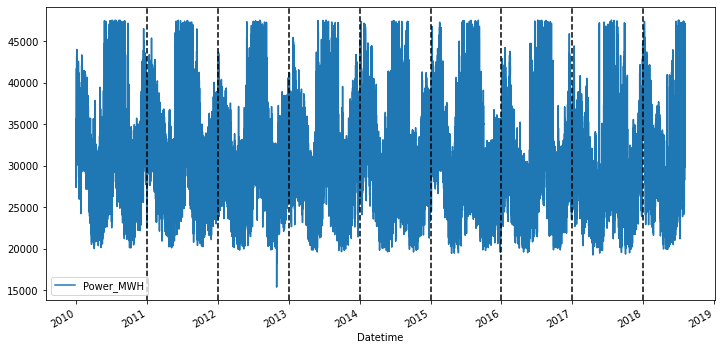

In [12]:
ax = data.plot(y='Power_MWH', figsize=(12,6))
xcoords = ['2011-01-01','2012-01-01', '2013-01-01', '2014-01-01', '2015-01-01',
          '2016-01-01', '2017-01-01', '2018-01-01']
for xc in xcoords:
    plt.axvline(x=xc, color='black', linestyle='--')

It seems like there’s definitely a trend here. In this case, it appears the seasonality has a period of one year. Next, we’ll look into a tool we can use to further examine the seasonality and break down our time series into its trend, seasonal, and residual components. 

In [13]:
statistics = data.describe()
print("Basic Statistics:\n", statistics)


Basic Statistics:
           Power_MWH
count  73428.000000
mean   31251.944572
std     5803.321855
min    15390.000000
25%    27118.000000
50%    30678.000000
75%    34932.000000
max    47532.000000


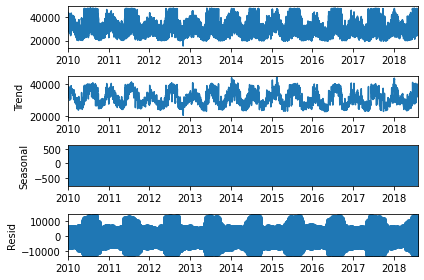

In [14]:
from statsmodels.tsa.seasonal import seasonal_decompose

#data.set_index('Datetime', inplace=True)

analysis = data[['Power_MWH']].copy()


decompose_result_mult = seasonal_decompose(analysis, model="additive", period=24)

trend = decompose_result_mult.trend
seasonal = decompose_result_mult.seasonal
residual = decompose_result_mult.resid

decompose_result_mult.plot();

## Feature Engineering

Time features capture the temporal patterns and seasonality in the data. These features are essential for understanding how energy consumption varies over different time scales. For instance:
Year: Helps identify long-term trends and changes over the years.
Month: Captures monthly seasonality, such as higher energy consumption during summer or winter months.
Day: Reflects daily patterns, such as increased consumption during daytime and reduced consumption at night.
Hour: Provides granularity to distinguish between consumption patterns during different hours of the day.
Day of the Week: Helps capture weekly patterns, such as higher consumption on weekdays compared to weekends.

Lagged features capture autocorrelation or temporal dependencies in the data. Energy consumption at a particular time may be influenced by past values. For example:
Lag1: Represents the energy consumption one hour ago. This can help capture short-term dependencies.
Lag2: Represents the energy consumption two hours ago. It provides another level of lagged information.

Rolling statistics help capture trends and variability in the data over a specified window size. These features are useful for identifying changes in energy consumption patterns. For example:
Rolling Mean (e.g., 7-day): Provides a smoothed representation of consumption trends over a short-term period (e.g., weekly).
Rolling Standard Deviation (e.g., 7-day): Measures the variability or volatility of consumption within the same short-term window.

Add date-related columns to a DataFrame based on a datetime index.

In [15]:
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

# Define the calendar
cal = calendar()

# Add date-related columns
data["Date"] = data.index.date
data["Hour"] = data.index.hour
data["DayofWeek"] = data.index.dayofweek
data["Month"] = data.index.month
data["Quarter"] = data.index.quarter
data["DayofYear"] = data.index.dayofyear
data["Year"] = data.index.year
data["Season"] = data.index.quarter
data["Holiday"] = data["Date"].isin([date.date() for date in cal.holidays()]).astype(int)

data.head()

,Power_MWH,Date,Hour,DayofWeek,Month,Quarter,DayofYear,Year,Season,Holiday
Datetime,,,,,,,,,,
2010-01-01 00:00:00,31647.0,2010-01-01,0,4,1,1,1,2010,1,1
2010-01-01 01:00:00,30075.0,2010-01-01,1,4,1,1,1,2010,1,1
2010-01-01 02:00:00,28907.0,2010-01-01,2,4,1,1,1,2010,1,1
2010-01-01 03:00:00,27906.0,2010-01-01,3,4,1,1,1,2010,1,1
2010-01-01 04:00:00,27373.0,2010-01-01,4,4,1,1,1,2010,1,1


In [16]:
data['lag_1'] = data['Power_MWH'].shift(1)
data['lag_2'] = data['Power_MWH'].shift(2)
data.head()

,Power_MWH,Date,Hour,DayofWeek,Month,Quarter,DayofYear,Year,Season,Holiday,lag_1,lag_2
Datetime,,,,,,,,,,,,
2010-01-01 00:00:00,31647.0,2010-01-01,0,4,1,1,1,2010,1,1,NaN,NaN
2010-01-01 01:00:00,30075.0,2010-01-01,1,4,1,1,1,2010,1,1,31647.0,NaN
2010-01-01 02:00:00,28907.0,2010-01-01,2,4,1,1,1,2010,1,1,30075.0,31647.0
2010-01-01 03:00:00,27906.0,2010-01-01,3,4,1,1,1,2010,1,1,28907.0,30075.0
2010-01-01 04:00:00,27373.0,2010-01-01,4,4,1,1,1,2010,1,1,27906.0,28907.0


In [17]:
data['rolling_mean'] = data['Power_MWH'].rolling(window=7).mean()
data['rolling_std'] = data['Power_MWH'].rolling(window=7).std()
data.head(10)

,Power_MWH,Date,Hour,DayofWeek,Month,Quarter,DayofYear,Year,Season,Holiday,lag_1,lag_2,rolling_mean,rolling_std
Datetime,,,,,,,,,,,,,,
2010-01-01 00:00:00,31647.0,2010-01-01,0,4,1,1,1,2010,1,1,NaN,NaN,NaN,NaN
2010-01-01 01:00:00,30075.0,2010-01-01,1,4,1,1,1,2010,1,1,31647.0,NaN,NaN,NaN
2010-01-01 02:00:00,28907.0,2010-01-01,2,4,1,1,1,2010,1,1,30075.0,31647.0,NaN,NaN
2010-01-01 03:00:00,27906.0,2010-01-01,3,4,1,1,1,2010,1,1,28907.0,30075.0,NaN,NaN
2010-01-01 04:00:00,27373.0,2010-01-01,4,4,1,1,1,2010,1,1,27906.0,28907.0,NaN,NaN
2010-01-01 05:00:00,27411.0,2010-01-01,5,4,1,1,1,2010,1,1,27373.0,27906.0,NaN,NaN
2010-01-01 06:00:00,27955.0,2010-01-01,6,4,1,1,1,2010,1,1,27411.0,27373.0,28753.428571,1591.970043
2010-01-01 07:00:00,28696.0,2010-01-01,7,4,1,1,1,2010,1,1,27955.0,27411.0,28331.857143,965.461622
2010-01-01 08:00:00,29003.0,2010-01-01,8,4,1,1,1,2010,1,1,28696.0,27955.0,28178.714286,688.042323


In [18]:
data.shape

(73428, 14)

In [19]:
data.isnull().sum()

Power_MWH       0
Date            0
Hour            0
DayofWeek       0
Month           0
Quarter         0
DayofYear       0
Year            0
Season          0
Holiday         0
lag_1           1
lag_2           2
rolling_mean    6
rolling_std     6
dtype: int64

In [20]:
data.dropna(inplace=True)

### Dataset Split

In [39]:
def split_datasets(data: pd.DataFrame, threshold_date: str):
    """
    Function used to split a DataFrame into train and test DataFrames based on a given threshold date.

    Args:
        df (pd.DataFrame): An original DataFrame.
        threshold_date (str): A threshold date in "YYYY-MM-DD" format.

    Returns:
        tuple: A tuple containing the train DataFrame and test DataFrame.
    """
    # Convert the threshold_date to a datetime object
    threshold_date = pd.to_datetime(threshold_date)

    # Split the DataFrame into train and test DataFrames
    train_df = data[data.index < threshold_date]
    test_df = data[data.index >= threshold_date]

    return train_df, test_df


# Apply the split_datasets function
train_df, test_df = split_datasets(data, "2016-01-01")

In [22]:
train_df.reset_index(inplace=True)
test_df.reset_index(inplace=True)

In [ ]:
import seaborn as sns

# Set the figure size and layout
plt.figure(figsize=(12, 6))
sns.set_style("darkgrid")

# Plot the power consumption of the train dataset over time
sns.lineplot(data=train_df, x="Datetime", y="Power_MWH", label="Train Data", color="b")

# Plot the power consumption of the test dataset over time
sns.lineplot(data=test_df, x="Datetime", y="Power_MWH", label="Test Data", color="r")

# Set labels and title
plt.title("Power Consumption Over Time")
plt.xlabel("Date")
plt.ylabel("Power Consumption")
plt.xticks(rotation=45)

# Display the plot
plt.show()

In [ ]:
train_df.drop(['Datetime'], axis=1, inplace=True)
test_df.drop(['Datetime'], axis=1, inplace=True)

In [42]:
train_df.drop(['Date'], axis=1, inplace=True)
test_df.drop(['Date'], axis=1, inplace=True)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/frame.py:4164: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [43]:
X_train = train_df.drop(columns=['Power_MWH'])  # Exclude the target variable
X_test = test_df.drop(columns=['Power_MWH'])  # Exclude the target variable

y_train = train_df['Power_MWH']  # Target variable for training
y_test = test_df['Power_MWH']  # Target variable for testing

## Modelling

In [44]:
import xgboost as xgb
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=3000,
                       early_stopping_rounds=100,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[18:58:13] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:31670.44209	validation_1-rmse:30999.47144


[100]	validation_0-rmse:11672.81825	validation_1-rmse:11379.95971
[200]	validation_0-rmse:4407.41852	validation_1-rmse:4260.45233
[300]	validation_0-rmse:1846.21941	validation_1-rmse:1760.97409
[400]	validation_0-rmse:1035.01302	validation_1-rmse:988.21147
[500]	validation_0-rmse:807.43297	validation_1-rmse:787.40757
[600]	validation_0-rmse:730.16692	validation_1-rmse:722.14312
[700]	validation_0-rmse:683.55371	validation_1-rmse:680.70924
[800]	validation_0-rmse:648.14682	validation_1-rmse:647.92321
[900]	validation_0-rmse:623.11172	validation_1-rmse:624.70151
[1000]	validation_0-rmse:601.89394	validation_1-rmse:603.62765
[1100]	validation_0-rmse:571.86625	validation_1-rmse:576.77128
[1200]	validation_0-rmse:556.02142	validation_1-rmse:561.80881
[1300]	validation_0-rmse:542.17894	validation_1-rmse:549.43931
[1400]	validation_0-rmse:529.46716	validation_1-rmse:538.44463
[1500]	validation_0-rmse:518.35793	validation_1-rmse:528.80800
[1600]	validation_0-rmse:508.64680	validation_1-rmse:52

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=100, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.01, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=3, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=3000,
             n_jobs=0, num_parallel_tree=1, objective='reg:linear',
             predictor='auto', random_state=0, reg_alpha=0, ...)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


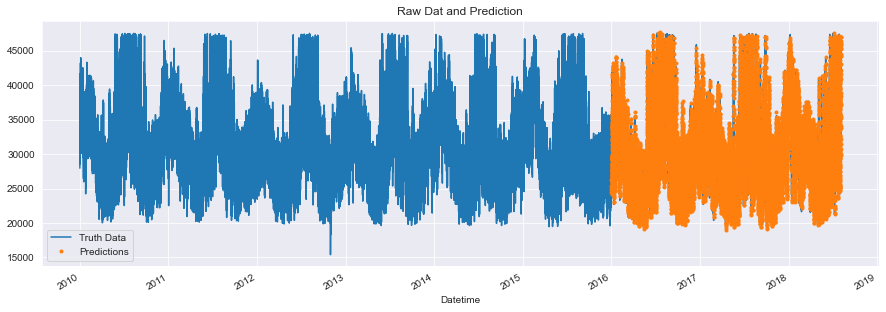

In [45]:
test_df['prediction'] = reg.predict(X_test)
df = data.merge(test_df[['prediction']], how='left', left_index=True, right_index=True)
ax = data[['Power_MWH']].plot(figsize=(15, 5))
df['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Dat and Prediction')
plt.show()

In [48]:
from sklearn.metrics import mean_squared_error
score = np.sqrt(mean_squared_error(test_df['Power_MWH'], test_df['prediction']))
print(f'RMSE Score on Test set: {score:0.3f}')

RMSE Score on Test set: 445.630


Linear regression can be a suitable choice if your time series data shows relatively linear trends and relationships.

Pros: Simple and interpretable, quick to train, can capture linear trends and relationships in the data.
Cons: Limited ability to capture complex nonlinear patterns and seasonality.

In [28]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Calculate RMSE (Root Mean Squared Error)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Linear Regression RMSE: {rmse}")

Linear Regression RMSE: 586.6163539264477


In [29]:
test_df['LR_predictions'] = y_pred
data_all = pd.concat([train_df, test_df], sort=False)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [51]:
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Check for stationarity (if not stationary, we'll need to difference the series)
def check_stationarity(timeseries):
    # Perform the Augmented Dickey-Fuller test
    result = adfuller(timeseries, autolag='AIC')
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'   {key}: {value}')
    
    return result[1] <= 0.05  # Return True if stationary, False otherwise

# Plot ACF and PACF for parameter selection
def plot_acf_pacf(timeseries):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
    plot_acf(timeseries, ax=ax1, lags=40)
    plot_pacf(timeseries, ax=ax2, lags=40)
    plt.show()

is_stationary = check_stationarity(data['Power_MWH'])

ADF Statistic: -14.446438399644473
p-value: 7.216620447761838e-27
Critical Values:
   1%: -3.4304391381170474
   5%: -2.8615793974935895
   10%: -2.566790969934689


In [52]:
is_stationary

True

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:              Power_MWH   No. Observations:                73428
Model:                 ARIMA(1, 1, 1)   Log Likelihood             -584023.279
Date:                Thu, 21 Sep 2023   AIC                        1168052.558
Time:                        18:35:41   BIC                        1168080.170
Sample:                             0   HQIC                       1168061.056
                              - 73428                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7027      0.002    374.240      0.000       0.699       0.706
ma.L1          0.5614      0.003    204.406      0.000       0.556       0.567
sigma2      4.718e+05   1550.106    304.377      0.0

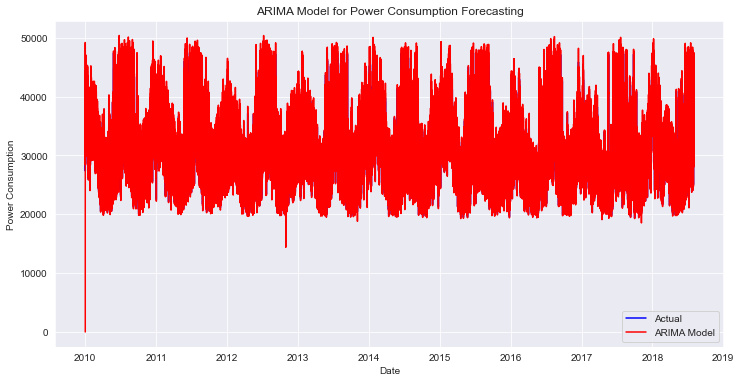

In [80]:
# Calculate the first-order difference
data['Power_MWH_diff'] = data['Power_MWH'] - data['Power_MWH'].shift(1)

# If the data is now stationary, we can proceed with ARIMA modeling

p = 1  # Autoregressive order
d = 1  # Degree of differencing
q = 1  # Moving average order

# Plot ACF and PACF to determine p and q values
#plot_acf_pacf(data['Power_MWH_diff'])

# Fit the ARIMA model
model = sm.tsa.ARIMA(data['Power_MWH'], order=(p, d, q))
results = model.fit()

# Print model summary
print(results.summary())

    # Plot the predicted vs. actual values
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Power_MWH'], color='blue', label='Actual')
plt.plot(data.index, results.fittedvalues, color='red', label='ARIMA Model')
plt.title('ARIMA Model for Power Consumption Forecasting')
plt.xlabel('Date')
plt.ylabel('Power Consumption')
plt.legend()
plt.show()
    
 

In [79]:
np.sqrt(mean_squared_error(data['Power_MWH'], results.fittedvalues))

700.5488135154202

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


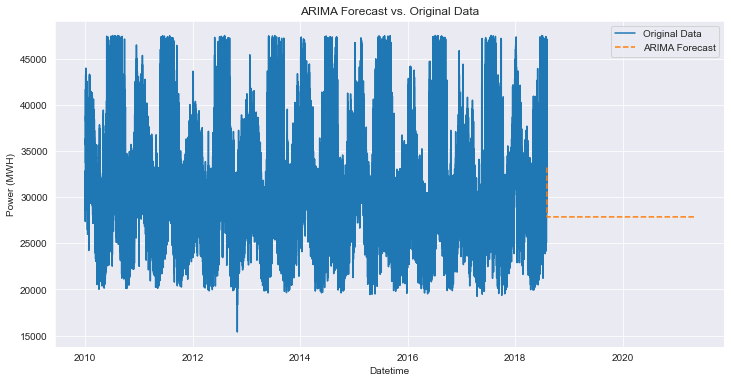

In [77]:
forecast_steps = 24000  # For example, forecast the next 24 hours

# Forecast future values
forecast = results.forecast(steps=forecast_steps)


# Plot the original data and the forecast
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Power_MWH'], label='Original Data')
plt.plot(pd.date_range(start=data.index[-1], periods=forecast_steps+1, freq='H')[1:], forecast, label='ARIMA Forecast', linestyle='--')
plt.xlabel('Datetime')
plt.ylabel('Power (MWH)')
plt.title('ARIMA Forecast vs. Original Data')
plt.legend()
plt.show()

In [78]:
forecast

73428    33220.002868
73429    31627.714608
73430    30508.833270
73431    29722.609142
73432    29170.139136
             ...     
97423    27864.394857
97424    27864.394857
97425    27864.394857
97426    27864.394857
97427    27864.394857
Name: predicted_mean, Length: 24000, dtype: float64

In [71]:
daily = data.resample('d').sum()

In [72]:
decomposition = seasonal_decompose(daily['Power_MWH'], model='additive')
average_seasonal_pattern = decomposition.seasonal.mean()
baseline_predictions = average_seasonal_pattern

In [73]:

df_reconstructed = pd.concat(
    [decomposition.seasonal, 
     decomposition.trend, 
     decomposition.resid, 
     decomposition.trend * decomposition.resid, 
     decomposition.observed], axis=1)
df_reconstructed.columns = ['seasonal', 'trend', 'remainders', 'seasonal_adj', 'actual_values']
df_reconstructed.tail()

,seasonal,trend,remainders,seasonal_adj,actual_values
Datetime,,,,,
2018-07-30,7213.315491,833376.285714,-49611.601206,-4.134513e+10,790978.0
2018-07-31,12898.909560,707503.428571,108535.661868,7.678935e+10,828938.0
2018-08-01,16814.085511,NaN,NaN,NaN,747081.0
2018-08-02,17977.254894,NaN,NaN,NaN,950233.0
2018-08-03,10596.174677,NaN,NaN,NaN,35486.0
